# DWD Weather Station Data
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/

In [1]:
import os
import re
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from itertools import combinations
from shapely.geometry import Point

<b>Weather Stations in Germany for:</b></br></br>
relative humidity (%)</br>
air pressure at station level (hPa)</br>
air temperature near ground (°C)</br>
air temperature at 2 m (°C)</br>
dew point temperature (°C)</br>

diffuse radiation (J/cm<sup>2</sup>)</br>
global radiation (J/cm<sup>2</sup>)</br>
sunshine duration (hours)</br>

wind direction (degree)</br>
wind velocity (m/s)

In [2]:
directory = 'data'
target_dir = 'data/final'
to_date = '2024-11-25'
from_date = '2023-08-01'

column_names = [
    "Stations_id", "von_datum", "bis_datum", "Stationshoehe",
    "geoBreite", "geoLaenge", "Stationsname", "Bundesland", "Abgabe"
]

# get all station files
station_files = []
for root, dirs, files in os.walk(directory):
    if ('data/Archiv' in root) | ('data/final' in root):
        continue
    for file in files:
        if 'Stationen' in file:
            station_files.append(os.path.join(root, file))

# read all station files
stations = None
for station in station_files:
    df_station = pd.read_fwf(station, 
                             encoding='latin1',
                             skiprows=2,
                             names=column_names)
    df_station['von_datum'] = pd.to_datetime(df_station['von_datum'], format='%Y%m%d')
    df_station['bis_datum'] = pd.to_datetime(df_station['bis_datum'], format='%Y%m%d')
    df_station.drop(['Abgabe'], axis=1, inplace=True)
    table_name = station.split('/')[1]
    df_station['Table'] = table_name
    if station != None:
        stations = pd.concat([stations, df_station], ignore_index=True)
    else:
        stations = df_station.copy()
stations['Stations_id'] = stations["Stations_id"].apply(lambda x: f"{x:05d}")

In [3]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Stations_id    2473 non-null   object        
 1   von_datum      2473 non-null   datetime64[ns]
 2   bis_datum      2473 non-null   datetime64[ns]
 3   Stationshoehe  2473 non-null   int64         
 4   geoBreite      2473 non-null   float64       
 5   geoLaenge      2473 non-null   float64       
 6   Stationsname   2473 non-null   object        
 7   Bundesland     2473 non-null   object        
 8   Table          2473 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 174.0+ KB


In [4]:
for root, dirs, files in os.walk(directory):
    if ('data/Archiv' in root) | ('data/final' in root):
        continue
    print(f'In {root} are {len(files)} files.')

print('')
print(stations.groupby('Table').size().sort_index(ascending=False))

print('\n It is likely that data is not available for all stations.')

In data are 0 files.
In data/solar are 245 files.
In data/air_temperature are 478 files.
In data/wind_test are 275 files.
In data/precipitation are 1357 files.

Table
wind_test           273
solar               325
precipitation      1355
air_temperature     520
dtype: int64

 It is likely that data is not available for all stations.


In [ ]:
stations.drop(stations[stations.bis_datum < to_date].index, inplace=True)
stations.drop(stations[stations.von_datum > from_date].index, inplace=True)

counts = stations.groupby(['Stations_id']).size().value_counts().sort_index()
table_counts = stations.groupby(['Stations_id', 'Table']).size()

print(f'{len(stations.Stations_id.unique())} unique weather stations \n')

for e, c in enumerate(counts, start=1):
    print(f'{c} stations with values in {e} tables.')

print('\nAbsolute number of stations for:')
stations.groupby('Table').size()

1347 unique weather stations 

884 stations with values in 1 tables.
232 stations with values in 2 tables.
99 stations with values in 3 tables.
132 stations with values in 4 tables.

Absolute number of stations for:


Table
air_temperature     463
precipitation      1281
solar               163
wind_test           266
dtype: int64

In [6]:
stations

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Table
1,00044,2007-04-02,2024-11-26,44,52.9336,8.2370,Großenkneten,Niedersachsen,solar
5,00150,2004-09-06,2024-11-26,215,49.7273,8.1164,Alzey,Rheinland-Pfalz,solar
7,00161,2011-08-30,2024-11-26,75,50.4237,7.4202,Andernach,Rheinland-Pfalz,solar
8,00164,1992-01-04,2024-11-26,54,53.0316,13.9908,Angermünde,Brandenburg,solar
10,00183,1991-11-02,2024-11-26,42,54.6791,13.4344,Arkona,Mecklenburg-Vorpommern,solar
...,...,...,...,...,...,...,...,...,...
2456,19768,2023-04-24,2025-01-13,235,49.6672,8.0228,Kirchheimbolanden/Pfalz,Rheinland-Pfalz,precipitation
2457,19777,2023-05-15,2025-01-13,420,50.3397,6.7611,Gerolstein-Üxheim,Rheinland-Pfalz,precipitation
2458,19782,2023-05-17,2025-01-13,429,50.3489,7.0778,Vordereifel-Virneburg,Rheinland-Pfalz,precipitation
2459,19816,2023-07-07,2025-01-13,223,49.5989,8.0367,Göllheim/Pfalz,Rheinland-Pfalz,precipitation


In [ ]:
# Precipitation has to be dropped, because most of the stations are separated for measuring precipitation and other meteorlogical factors
# Wind also has to be dropped because all the data is in wind_test
#labels = stations.loc[(stations.Table == 'precipitation') | (stations.Table == 'wind')].index
#stations.drop(labels, inplace=True)

grouped = stations.groupby(['Stations_id'])['Table'].apply(list)

combination_counts = {}
for categories in grouped:
    for pair in combinations(categories, 2):
        pair = tuple(sorted(pair))
        combination_counts[pair] = combination_counts.get(pair, 0) + 1
    
grouped_counts = stations.groupby(["Stations_id", "Table"]).size().unstack(fill_value=0)
single_entries = grouped_counts[grouped_counts.sum(axis=1) == 1].sum()

categories = ["air_temperature", "solar", "wind_test", 'precipitation']
matrix = pd.DataFrame(0, index=categories, columns=categories)

for (cat1, cat2), count in combination_counts.items():
    matrix.loc[cat1, cat2] += count
    matrix.loc[cat2, cat1] += count  

for category in categories:
    if category in single_entries:
        matrix.loc[category, category] = single_entries[category]
        
matrix

,air_temperature,solar,wind_test,precipitation
air_temperature,1,163,202,460
solar,163,0,134,161
wind_test,202,134,63,201
precipitation,460,161,201,820


In [8]:
valid_stations = (
    stations.groupby("Stations_id")["Table"]
    .apply(lambda x: set(x) == {"air_temperature", "solar", "wind_test", "precipitation"})
)

valid_stations_ids = valid_stations[valid_stations].index

stations3 = stations[stations["Stations_id"].isin(valid_stations_ids)]

132 unique weather stations after cleaning. 



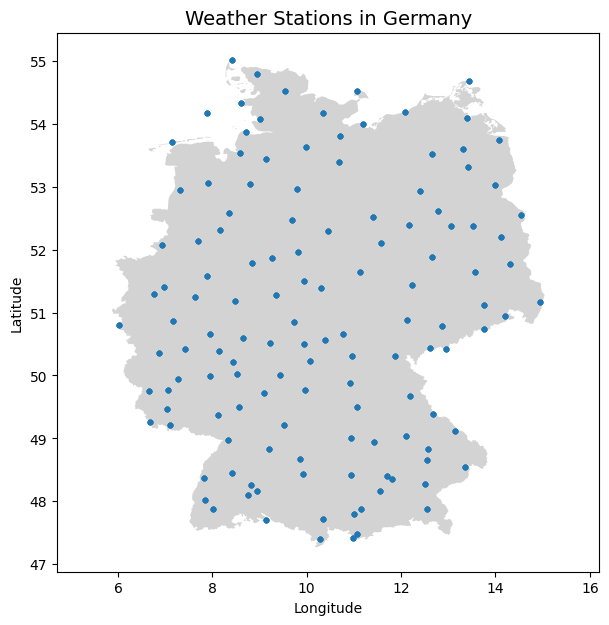

In [9]:
germany = gpd.read_file('geoBoundaries-DE.geojson')

geometry = [Point(xy) for xy in zip(stations3['geoLaenge'], stations3['geoBreite'])]
geo_df = gpd.GeoDataFrame(stations3, geometry=geometry)

print(f'{len(stations3.Stations_id.unique())} unique weather stations after cleaning. \n')

fig, ax = plt.subplots(figsize=(7, 7))
germany.plot(ax=ax, color='lightgrey')  
geo_df.plot(ax=ax, 
            label='Stations', 
            markersize=10, 
            legend=True)

stretch_factor = 0.75 
ax.set_aspect(1 / stretch_factor, adjustable='datalim')

plt.title('Weather Stations in Germany', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [10]:
stations_ids = stations3.Stations_id.unique()

# get list of relevant station files
file_paths = []
for root, dirs, files in os.walk(directory):
    if ('data/Archiv' in root) | ('data/final' in root):
        continue
    for file in files:
        if 'produkt' in file:
            file_split = re.split(r'[_\.]', file)
            
            to_date_file = datetime.strptime(file_split[5], '%Y%m%d')
            
            in_date = not to_date_file < datetime.strptime(to_date, '%Y-%m-%d')  
            in_ids = file_split[-2] in stations_ids
            
            if in_date and in_ids:
                file_paths.append(os.path.join(root, file))

In [11]:
# check if the list of files contains all relevant stations
extracted_data = []

for path in file_paths:
    parts = re.split(r'[\/_.]', path) 
    category = parts[1]
                   
    if category == "air":
        category = "air_temperature"
        date = parts[8]       
        station_id = parts[9]
    elif category == 'wind':
        category = 'wind_test'
        date = parts[8]       
        station_id = parts[9] 
    else:
        date = parts[7]       
        station_id = parts[8]
           
    extracted_data.append([category, date, station_id])

df_proof = pd.DataFrame(extracted_data, columns=["Category", "Date", "Stations_ID"])


In [12]:
df_proof.groupby('Category').size()

Category
air_temperature    132
precipitation      132
solar              132
wind_test          132
dtype: int64

In [13]:
stations_ids

array(['00161', '00164', '00183', '00232', '00282', '00342', '00427',
       '00460', '00591', '00596', '00662', '00691', '00701', '00704',
       '00840', '00853', '00856', '00867', '00880', '00891', '00953',
       '00963', '01001', '01048', '01078', '01200', '01262', '01303',
       '01346', '01358', '01420', '01443', '01468', '01503', '01544',
       '01550', '01580', '01587', '01605', '01612', '01639', '01684',
       '01691', '01757', '01766', '01832', '01975', '02014', '02044',
       '02115', '02171', '02261', '02290', '02483', '02559', '02597',
       '02601', '02638', '02667', '02712', '02794', '02812', '02907',
       '02925', '02932', '02985', '03015', '03028', '03032', '03086',
       '03098', '03126', '03158', '03167', '03231', '03268', '03287',
       '03366', '03379', '03631', '03660', '03668', '03730', '03761',
       '03987', '04104', '04177', '04271', '04336', '04393', '04466',
       '04501', '04745', '04887', '04911', '04928', '05029', '05100',
       '05109', '051

In [14]:
proof = [id for id in df_proof.Stations_ID.unique() if not id in stations_ids]
        
if proof:
    print('There are inconsistent stations in your dataframe.')
else:
    print('The stations are consistent with your stations_ids list.')

The stations are consistent with your stations_ids list.


In [15]:
# group paths by stations_id

grouped = defaultdict(lambda: {"wind_test": None, "solar": None, "air_temperature": None, 'precipitation': None})

for path in file_paths:
    parts = re.split(r'[\/_.]', path)
    category = parts[1]  
    station_id = parts[-2]
    
    if category == "air":
        category = "air_temperature"
    if category == "wind":
        category = "wind_test"
    
    grouped[station_id][category] = path

structured_list = []
for station_id, paths in grouped.items():
    if all(paths[cat] for cat in ["wind_test", "precipitation", "solar", "air_temperature"]):
        structured_list.append([
            paths["air_temperature"],
            paths["wind_test"],
            paths["solar"],
            paths["precipitation"]
        ])

In [16]:
# merge dataframes by stations_ids

final_df = []

for ele in structured_list:
    station_df = None
    
    for file in ele:
        station_id = re.search(r'_(\d{5})\.txt$', file).group(1)
        raw = pd.read_csv(file, sep=';')
        raw['timestamp'] = pd.to_datetime(raw['MESS_DATUM'], format='%Y%m%d%H%M')
        raw.set_index('timestamp', inplace=True)
        raw.drop(['MESS_DATUM', '  QN', 'eor'], axis=1, inplace=True)
        raw['STATIONS_ID'] = station_id
        
        if station_df is not None:
            station_df = pd.merge(station_df, raw, how='inner', on=['timestamp', 'STATIONS_ID'])
        else:
            station_df = raw.copy()
    station_id = station_df.STATIONS_ID.iloc[0]
    cols = ['Stationshoehe', 'geoBreite', 'geoLaenge']
    col_vals = stations3[stations3.Stations_id == station_id][cols].drop_duplicates().values
    col_vals = np.tile(col_vals, (len(station_df), 1))
    station_df[cols[0]] = col_vals[:,0]
    station_df[cols[1]] = col_vals[:,1]
    station_df[cols[2]] = col_vals[:,2]
    
    final_df.append(station_df)

In [17]:
# write csv from final dataframes

os.makedirs(target_dir, exist_ok=True)
for df in final_df:
    file_name = f'Station_{str(df.STATIONS_ID.unique()[0])}.csv'
    dir = os.path.join(directory, 'final', file_name)
    df.to_csv(dir)